<a href="https://colab.research.google.com/github/ElektroDuck/CDMO_MCCVRP/blob/main/Luca/assignment_module_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment Module 2: Product Classification

The goal of this assignment is to implement a neural network that classifies smartphone pictures of products found in grocery stores. The assignment will be divided into two parts: first, you will be asked to implement from scratch your own neural network for image classification; then, you will fine-tune a pretrained network provided by PyTorch.


## Preliminaries: the dataset

The dataset you will be using contains natural images of products taken with a smartphone camera in different grocery stores:

<p align="center">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Granny-Smith.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Pink-Lady.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Lemon.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Banana.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Vine-Tomato.jpg" width="150">
</p>
<p align="center">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Yellow-Onion.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Green-Bell-Pepper.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Arla-Standard-Milk.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Oatly-Natural-Oatghurt.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Alpro-Fresh-Soy-Milk.jpg" width="150">
</p>

The products belong to the following 43 classes:
```
0.  Apple
1.  Avocado
2.  Banana
3.  Kiwi
4.  Lemon
5.  Lime
6.  Mango
7.  Melon
8.  Nectarine
9.  Orange
10. Papaya
11. Passion-Fruit
12. Peach
13. Pear
14. Pineapple
15. Plum
16. Pomegranate
17. Red-Grapefruit
18. Satsumas
19. Juice
20. Milk
21. Oatghurt
22. Oat-Milk
23. Sour-Cream
24. Sour-Milk
25. Soyghurt
26. Soy-Milk
27. Yoghurt
28. Asparagus
29. Aubergine
30. Cabbage
31. Carrots
32. Cucumber
33. Garlic
34. Ginger
35. Leek
36. Mushroom
37. Onion
38. Pepper
39. Potato
40. Red-Beet
41. Tomato
42. Zucchini
```

The dataset is split into training (`train`), validation (`val`), and test (`test`) set.

The following code cells download the dataset and define a `torch.utils.data.Dataset` class to access it. This `Dataset` class will be the starting point of your assignment: use it in your own code and build everything else around it.

In [1]:
!git clone https://github.com/marcusklasson/GroceryStoreDataset.git

fatal: destination path 'GroceryStoreDataset' already exists and is not an empty directory.


In [2]:
import csv
import random
import numpy as np
import pandas as pd


from typing import List, Tuple
from PIL import Image
from pathlib import Path
from typing import List, Tuple
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm


import torch
import torch.nn as nn
from torch import Tensor
import torch.nn.functional as F
from torch.utils.data import Dataset
from torchvision import transforms as T

In [3]:
def fix_random(seed: int) -> None:
    """Fix all the possible sources of randomness.

    Args:
        seed: the seed to use.
    """
    #np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

fix_random(seed=42)

In [4]:
class GroceryStoreDataset(Dataset):

    def __init__(self, split: str, transform=None) -> None:
        super().__init__()

        self.root = Path("GroceryStoreDataset/dataset")
        self.split = split
        self.paths, self.labels = self.read_file()

        self.transform = transform

    def __len__(self) -> int:
        return len(self.labels)

    def __getitem__(self, idx) -> Tuple[Tensor, int]:
        img = Image.open(self.root / self.paths[idx])
        #print(img.size) #used to see the size of the image, and to tune the input image size into the model
        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        return img, label

    def read_file(self) -> Tuple[List[str], List[int]]:
        paths = []
        labels = []

        with open(self.root / f"{self.split}.txt") as f:
            for line in f:
                # path, fine-grained class, coarse-grained class
                path, _, label = line.replace("\n", "").split(", ")
                paths.append(path), labels.append(int(label))

        return paths, labels

    def get_num_classes(self) -> int:
        return max(self.labels) + 1

In [5]:
#generate a dictionary that map each id of the rpoduct to its name

id_to_name = {}
with open('GroceryStoreDataset/dataset/classes.csv', 'r') as file:
    reader = csv.reader(file)
    next(reader)
    for row in reader:
        id_to_name[int(row[3])] = row[2]

## Preparation step: analysis of the dataset and preprocessing



### Dataset visualization
In order to create a good model the first thing to do is to understand the kind of data we are working on. For this reason as a first thing to do we visualize some of the images contained in the dataset.

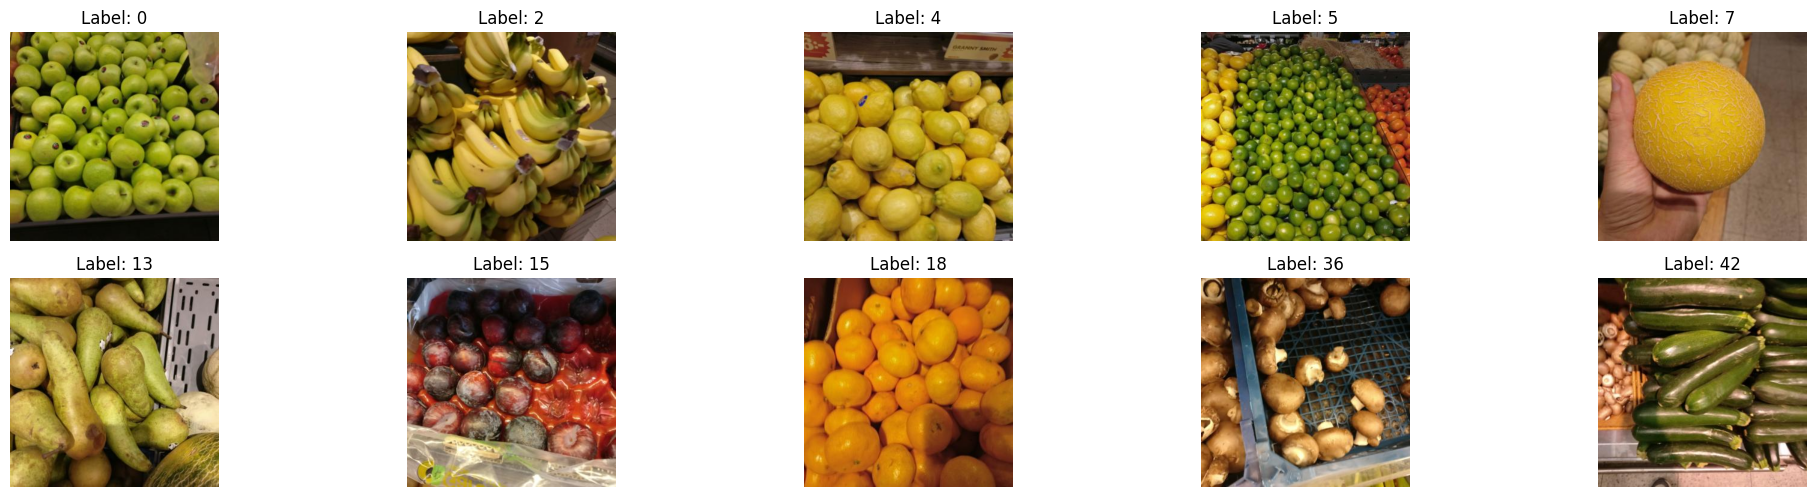

In [6]:
base_dataset = GroceryStoreDataset(split='train')

num_images_to_show = 10
random_indices = random.sample(range(len(base_dataset)), num_images_to_show)

random_indices.sort()

plt.figure(figsize=(20, 10))
for i, idx in enumerate(random_indices):
    image, label = base_dataset[idx]
    plt.subplot(4, 5, i + 1)
    plt.imshow(image)
    plt.title(f"Label: {label}")
    plt.axis('off')

plt.tight_layout()
plt.show()

### Transformation
In order to try to avoid overfitting, it is a good practice to add a transformation step. The transform operations are applied to the original images at every batch generation, meaning the images are transformed in every iteration. This ensures that the dataset remains unchanged, while the batch images are dynamically altered, providing a variety of inputs to the model during training.

Another crucial step is to carefully inspect the output of these transformations. A poorly designed transformation can lead to undesirable results, such as distorted images or loss of important features, which can negatively impact the model’s performance. Therefore, it is essential to validate that the transformations are applied correctly and that the augmented images still represent the original data accurately.

We are gonna perform this transformations:

  - `RandomHorizontalFlip()`: Randomly flips the image horizontally with a probability of 0.5, adding variability to the dataset.
  - `RandomRotation(40)`: Rotates the image by a random angle up to 40 degrees, helping the model become invariant to rotations.
  - `RandomResizedCrop(224, scale=(0.8, 1.0))`: Randomly crops the image to a size of 224x224 pixels, with the crop size ranging between 80% and 100% of the original dimensions, then resizes it to 224x224 pixels. This introduces variability in the cropping process. Extensive testing has shown that with a crop size from 80% to 100%, the subject of the image consistently remains part of the scene even after cropping.
  - `ToTensor()`: Converts the image to a PyTorch tensor, which is required for further processing in PyTorch models.


In [7]:
# Define data augmentation transformations
data_transforms = T.Compose([
    T.RandomHorizontalFlip(),
    T.RandomRotation(40),
    T.RandomResizedCrop(224, scale=(0.8, 1.0)),
    T.ToTensor()
])

# Create dataset with transformations
transofrmed_data = GroceryStoreDataset(split='train', transform=data_transforms)

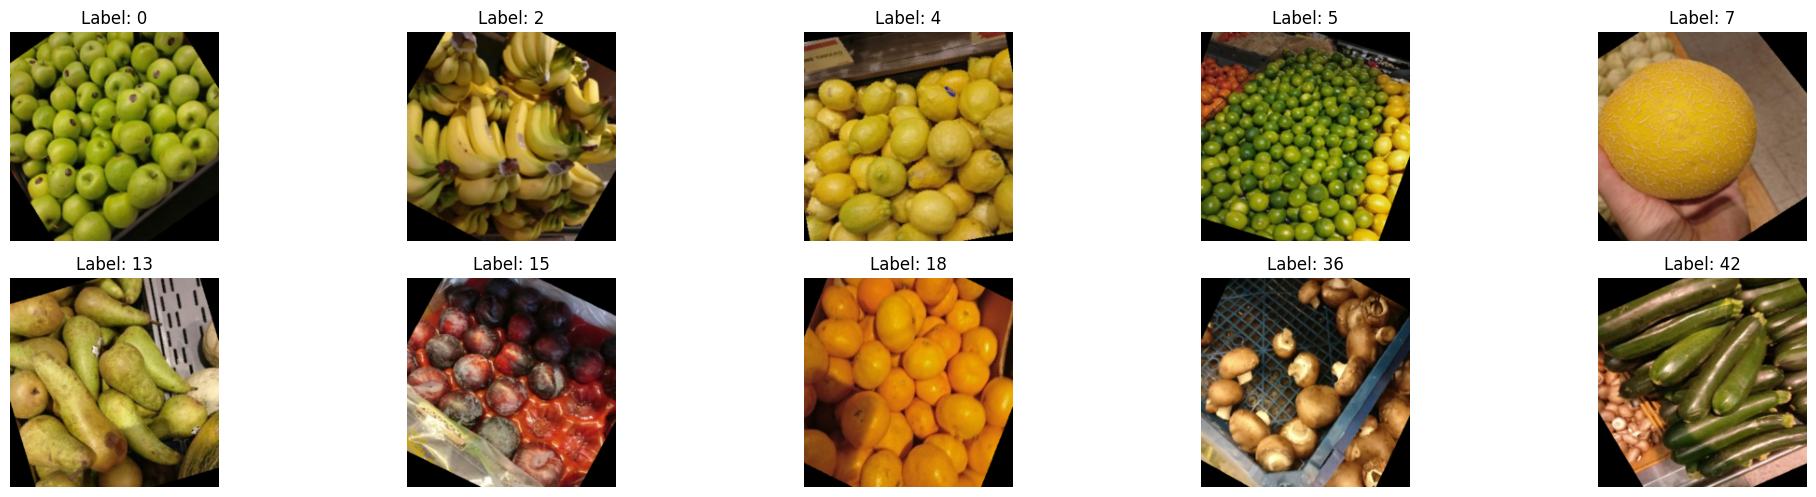

In [8]:
#print 20 example from the transformed_data
num_images_to_show = 20

plt.figure(figsize=(20, 10))
for i, idx in enumerate(random_indices):
    image, label = transofrmed_data[idx]
    plt.subplot(4, 5, i + 1)
    plt.imshow(image.permute(1, 2, 0))
    plt.title(f"Label: {label}")
    plt.axis('off')

plt.tight_layout()
plt.show()

### Dataset visualization

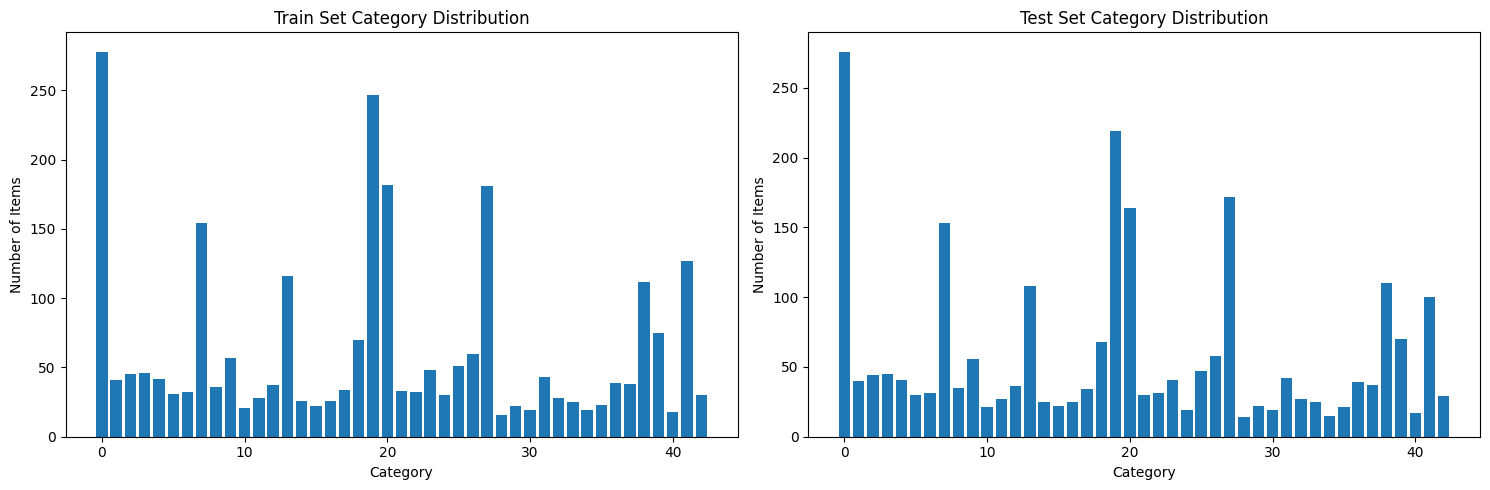

Train set Counter({0: 278, 19: 247, 20: 182, 27: 181, 7: 154, 41: 127, 13: 116, 38: 112, 39: 75, 18: 70, 26: 60, 9: 57, 25: 51, 23: 48, 3: 46, 2: 45, 31: 43, 4: 42, 1: 41, 36: 39, 37: 38, 12: 37, 8: 36, 17: 34, 21: 33, 6: 32, 22: 32, 5: 31, 24: 30, 42: 30, 11: 28, 32: 28, 14: 26, 16: 26, 33: 25, 35: 23, 15: 22, 29: 22, 10: 21, 30: 19, 34: 19, 40: 18, 28: 16})
Test set Counter({0: 276, 19: 219, 27: 172, 20: 164, 7: 153, 38: 110, 13: 108, 41: 100, 39: 70, 18: 68, 26: 58, 9: 56, 25: 47, 3: 45, 2: 44, 31: 42, 4: 41, 23: 41, 1: 40, 36: 39, 37: 37, 12: 36, 8: 35, 17: 34, 6: 31, 22: 31, 5: 30, 21: 30, 42: 29, 11: 27, 32: 27, 14: 25, 16: 25, 33: 25, 15: 22, 29: 22, 10: 21, 35: 21, 24: 19, 30: 19, 40: 17, 34: 15, 28: 14})
Validation set Counter({0: 276, 19: 219, 27: 172, 20: 164, 7: 153, 38: 110, 13: 108, 41: 100, 39: 70, 18: 68, 26: 58, 9: 56, 25: 47, 3: 45, 2: 44, 31: 42, 4: 41, 23: 41, 1: 40, 36: 39, 37: 37, 12: 36, 8: 35, 17: 34, 6: 31, 22: 31, 5: 30, 21: 30, 42: 29, 11: 27, 32: 27, 14: 25,

In [9]:
import matplotlib.pyplot as plt
from collections import Counter

# Load the train and test datasets
train_dataset = GroceryStoreDataset(split='train')
test_dataset = GroceryStoreDataset(split='test')

# Count the number of items for each category in the train and test set
train_counts = Counter(train_dataset.labels)
test_counts = Counter(test_dataset.labels)
val_counts = Counter(test_dataset.labels)

# Create a bar plot to visualize the distribution of categories
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.bar(train_counts.keys(), train_counts.values())
plt.title('Train Set Category Distribution')
plt.xlabel('Category')
plt.ylabel('Number of Items')

plt.subplot(1, 2, 2)
plt.bar(test_counts.keys(), test_counts.values())
plt.title('Test Set Category Distribution')
plt.xlabel('Category')
plt.ylabel('Number of Items')

plt.tight_layout()
plt.show()


print("Train set", train_counts)
print("Test set", test_counts)
print("Validation set", val_counts)

### Perform data augmentation

## Part 1: design your own network

Your goal is to implement a convolutional neural network for image classification and train it on `GroceryStoreDataset`. You should consider yourselves satisfied once you obtain a classification accuracy on the **validation** split of **around 60%**. You are free to achieve that however you want, except for a few rules you must follow:

- You **cannot** simply instantiate an off-the-self PyTorch network. Instead, you must construct your network as a composition of existing PyTorch layers. In more concrete terms, you can use e.g. `torch.nn.Linear`, but you **cannot** use e.g. `torchvision.models.alexnet`.

- Justify every *design choice* you make. Design choices include network architecture, training hyperparameters, and, possibly, dataset preprocessing steps. You can either (i) start from the simplest convolutional network you can think of and add complexity one step at a time, while showing how each step gets you closer to the target ~60%, or (ii) start from a model that is already able to achieve the desired accuracy and show how, by removing some of its components, its performance drops (i.e. an *ablation study*). You can *show* your results/improvements however you want: training plots, console-printed values or tables, or whatever else your heart desires: the clearer, the better.

Don't be too concerned with your network performance: the ~60% is just to give you an idea of when to stop. Keep in mind that a thoroughly justified model with lower accuracy will be rewarded **more** points than a poorly experimentally validated model with higher accuracy.

### Initial checks

Next, we will check if cuda is properky installed and our gpu is ready to go.

In [10]:
print("Using torch", torch.__version__)
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)} is available.")
else:
    print("No GPU available. Training will run on CPU.")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"The device is {device}")

Using torch 2.4.1+cu121
GPU: Tesla T4 is available.
The device is cuda


#### Breakdown of the key techniques used:

* **Loss Function**: CrossEntropyLoss. It measures the difference between the predicted probability distribution and the true target distribution.
* **Optimizer**: AdamW. It is an widely used optimizer that combines the benefits of adaptive learning rates with effective weight decay, leading to potentially better generalization.
* **Training and Validation**: The function iterates through a specified number of epochs (default 30). Each epoch involves training the model on the training data (train_loader) and evaluating its performance on the validation data (val_loader).
* **Metrics Tracking**: The function tracks and stores training and validation loss along with accuracy for each epoch. This allows for monitoring the model's performance during training and identifying potential issues.
* **Best Model Selection**: The model with the lowest validation loss is identified and saved as the "best model." This ensures selecting the model that performs best on unseen data (validation set).
* **Early stopping**. It is a technique used during training to halt the process when the model's performance on a validation set stops improving, preventing overfitting.


### Helper functions

Next, we will define functions that will be useful during our project.
* The functions **ncorrect**, **accuracy** and **train_loop** were provided in the assignment in order to implement the training and evaluation procedures that the students will need to develop their network. Only the train_loop function was modified, the biggest improvement being the implementation of the mechanism of early stopping mechanism.
* The **plot_losses** function provides a visual representation of the train and validation lossess of the models.
* The **train_pipeline** function steamlines the training process, while removing duplicate code.



In [11]:
#Training loop for the model
def ncorrect(scores, y):
    y_hat = torch.argmax(scores, -1)
    return (y_hat == y).sum()

def accuracy(scores, y):
    correct = ncorrect(scores, y)
    return correct.true_divide(y.shape[0])

def train_loop(model, train_dl, epochs, opt, val_dl=None, verbose=False, patience=5, min_delta=0):
    best_val_acc = 0
    best_params = []
    best_epoch = -1
    train_losses = []
    val_losses = []
    early_stop_counter = 0
    best_val_loss = float('inf')

    for e in tqdm(range(epochs)):
        model.train()
        # Train
        train_loss = 0
        train_samples = 0
        train_acc = 0
        for train_data in train_dl:
            imgs = train_data[0].to(device)
            labels = train_data[1].to(device)
            scores = model(imgs)
            loss = F.cross_entropy(scores, labels)
            train_loss += loss.item() * imgs.shape[0]
            train_samples += imgs.shape[0]
            train_acc += ncorrect(scores, labels).item()

            opt.zero_grad()  # clear
            loss.backward()  # fill
            opt.step()       # use

        train_acc /= train_samples
        train_loss /= train_samples
        train_losses.append(train_loss)


        # Validation
        model.eval()
        with torch.no_grad():
            val_loss = 0
            val_samples = 0
            val_acc = 0
            if val_dl is not None:
                for val_data in val_dl:
                    imgs = val_data[0].to(device)
                    labels = val_data[1].to(device)
                    val_scores = model(imgs)
                    val_loss += F.cross_entropy(val_scores, labels).item() * imgs.shape[0]
                    val_samples += imgs.shape[0]
                    val_acc += ncorrect(val_scores, labels).item()
                val_acc /= val_samples
                val_loss /= val_samples
                val_losses.append(val_loss)


            # Early Stopping
            if val_dl is not None:
                if val_loss < best_val_loss - min_delta:
                    best_val_loss = val_loss
                    early_stop_counter = 0
                else:
                    early_stop_counter += 1

                if early_stop_counter >= patience:
                    print(f"Early stopping at epoch {e+1}")
                    break

            if val_dl is None or val_acc > best_val_acc:
                best_val_acc = val_acc if val_dl is not None else 0
                best_params = model.state_dict()
                torch.save(best_params, "best_model.pth")
                best_epoch = e

        if verbose and e % 3 == 0:
            print(f"Epoch {e}: train loss {train_loss:.3f} - train acc {train_acc:.3f}" + ("" if val_dl is None else f" - valid loss {val_loss:.3f} - valid acc {val_acc:.3f}"))
            print(f"Epoch {e}: best acc {best_val_acc:.3f}")

    if verbose and val_dl is not None:
        print(f"Best epoch {best_epoch}, best acc {best_val_acc}")

    return best_val_acc, best_params, best_epoch, train_losses, val_losses

def plot_losses(train_losses, val_losses, best_epoch):

    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')

    # Mark the best epoch
    plt.scatter(best_epoch + 1, val_losses[best_epoch], color='red', label='Best Epoch', zorder=5)

    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

def train_pipeline(model, train_loader, num_epochs, validation_loader, verbose, optimizer = None, patience=5, min_delta=0.01):
    """
    Function that organizes the training process.
    This function sends the model to a device, and performs the training loop.
    It returns the best accuracy, best parameters, and the epoch where the model achieved peak performace.
    """
    model.to(device)

    best_val_acc, best_params, best_epoch, train_losses, val_losses = train_loop(
        model,
        train_loader,
        num_epochs,
        optimizer,
        validation_loader,
        verbose,
        patience,
        min_delta
    )

    return best_val_acc, best_params, best_epoch, train_losses, val_losses

### Hyperparameters

#### Breakdown of the key hyperparameters used:
* **batch_size**. This parameter determines how many samples are processed before the model's internal parameters are updated. A batch size of 64 is chosen as it provides a good balance between computational efficiency and the model's ability to generalize.
* **num_epochs**. This specifies the number of complete passes through the training dataset.
* **learning_rate**. The learning rate controls how much the model's weights are adjusted in response to the estimated error each time the model weights are updated.
* **hidden_dim**. This defines the size of the hidden layer in the fully connected part of the network. An arbitrary dimension of 1024 was chosen for the initial model.
* **verbose**. If True, will show informations about training progression.
* **dropout**. It is a regularization technique that prevents overfitting by randomly setting a fraction of the neurons to zero during training.
* **patience**. Represents the number of epochs after which the training will be stopped if no improvement in validation loss is detected
* **min_delta**. It represents the the minimum change in validation loss that qualifies as an improvement.
* **image_size**. The images that will be used in both training and evaluating the network will be resized to the dimension: (image_size, image_size). The number of channels will remain 3, as we will use RGB images.
* **n_classes**. Parameter that defines the dimension of the last layer of the network. Each neuron in this network will corespond to a category in the dataset.

In [12]:
#hyperparameters to be tunned
image_size = 300
batch_size = 64
min_delta = 0
patience = 5
batch_size = 64
num_epochs = 40
learning_rate = 1e-3
hidden_dim = 1024
verbose=True
dropout = 0.5

### Dataset

#### Dataset preprocessing and preparation is realized in several steps
1. Transform the images into tensor format
2. Resize the image to ensure proper dimensions.
The second step is a good practice, as resizing images to a square shape ensures consistent input dimensions, simplifies data processing, preserves aspect ratio, and improves computational efficiency in CNN training. (source: https://eitca.org/artificial-intelligence/eitc-ai-dltf-deep-learning-with-tensorflow/using-convolutional-neural-network-to-identify-dogs-vs-cats/introduction-and-preprocessing/examination-review-introduction-and-preprocessing/why-is-it-necessary-to-resize-the-images-to-a-square-shape/)
3. Define the Dataloaders for training, testing and validation, using the provided functions.

In [13]:
train_transform = basic_transform = T.Compose([
    T.RandomHorizontalFlip(),
    T.RandomRotation(40),
    T.RandomResizedCrop(224, scale=(0.8, 1.0)),
    T.ToTensor(),
    T.Resize((image_size, image_size)),
])

basic_transform = T.Compose([
    T.ToTensor(),
    T.Resize((image_size, image_size)),
])

In [14]:
#Divide the dataset into training and test sets
train_dataset = GroceryStoreDataset("train", transform=train_transform)
test_dataset = GroceryStoreDataset("test", transform=basic_transform)
validation_dataset = GroceryStoreDataset("val", transform=basic_transform)

In [15]:
#Define the loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size)

In [16]:
# This hyperparameter is defined dynamically here, as it is dependent on the definition of the dataset loaders.
n_classes = train_dataset.get_num_classes()
print(f"There are {n_classes} classification categories")

There are 43 classification categories


# Model definition

# First Model

The first model presented is a simple network, that uses the fundamental blocks of a of a Convolutional Neural Network(CNN).

A CNN is a Neural Network that uses as model the human brain and how it processes visual information. It takes the input, processes it by extracting certain features, and generates an output.

The basic layers of a CNN are:
* Convolutional layers
* ReLU layers
* Pooling layers
* Fully connected layer
* Dropout layer



1. **Convolutional layers** are key components in image classifiers, designed to extract features like edges and shapes from images. They work by applying a filter to the input, producing a feature map that highlights specific characteristics. This process, known as convolution, combines the input and filter to detect important features within the image, such as lines or edges.

2. **ReLU layers**(Rectified Linear Unit) in our network plays the role of an activation function. The main goal of an activation function is to add non-linearity to the computation, thus enhacing the learning capabilities of the network. In particular, ReLU layers takes the feature map, and transforms brings the negative values to 0. For example, if a feature in the feature map has the value -5, it will be substituted with 0. The positive values remain unchanged.

3. **Pooling layers** run a filter over the input(feature) matrix and extract a value that encapsulates information for a given region. The most common pooling type is max pooling. In the following image, we can see that for each section, the maximum value is extracted. One of the main advantages of this procedure is downsizing the image size.

![image.png](attachment:9cf48de9-b9ce-416c-b51a-a9bfe2e03a88.png)

(Image and content source: https://levity.ai/blog/how-do-image-classifiers-work#:~:text=Pooling%20layer,-In%20the%20process&text=The%20most%20common%20pooling%20approach%20is%20max%20pooling.&text=In%20the%20visualization%2C%20a%202x2,value%20to%20the%20output%20matrix).



4. **Fully connected layers** take the information of the last pooling layer and processes it.

5. **Dropout layer** are a regularization technique that randomly sets a fraction of the nodes to zero during training to prevent overfitting. Its role is to make the network more robust by ensuring it doesn't rely too heavily on specific nodes, leading to better generalization. (https://databasecamp.de/en/ml/dropout-layer-en#google_vignette)

In this network, we have a parameter(last_conv_output_size) dependant on the convolutional layer. This parameter is the input dimension of the dense layer. Next, we will explain the calculus.

* The image input dimension is 300x300. In the first convolutional layer, this does not change, but in the output we will have 16 chanels, instead of 3.
* In the following MaxPool layer, the dimension is halfed, as we have a 2x2 kernel with a stride of 2. The number of the channels remains 16
* In the second convolutional layer, the number of channels is doubled to 32. The image size remains the same.
* In the last MaxPoolLayer, the image is downsized once again, se we will have an image with a dimension of 75x75, and 32 channels.

Formula: Flattened Size = Number of Channels * Height * Width

Calculation: 32 * 75 * 75 = 180000

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvolNet(nn.Module):
    def __init__(self, hidden_dim, n_classes, conv_layers=None, dropout = 0.5):
        super().__init__()

        self.conv_layers = nn.ModuleList(conv_layers) if conv_layers else nn.ModuleList()

        self.last_conv_output_size = 180000 #computed parameter

        # Initialize the fully connected layers
        self.first = nn.Linear(self.last_conv_output_size, hidden_dim)
        self.last = nn.Linear(hidden_dim, n_classes)

        self.drop = nn.Dropout(dropout)
        self.relu = nn.ReLU()

    def forward(self, x):
        for layer in self.conv_layers:
            x = layer(x)

        x = torch.flatten(x, 1)

        x = self.drop(self.relu(self.first(x)))
        x = self.last(x)

        return x

# Define the convolutional layers
conv_layers = [
    nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
]

first_model= ConvolNet(
    hidden_dim,
    n_classes,
    conv_layers=conv_layers,
    dropout = dropout
)

print(first_model)

ConvolNet(
  (conv_layers): ModuleList(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (first): Linear(in_features=180000, out_features=1024, bias=True)
  (last): Linear(in_features=1024, out_features=43, bias=True)
  (drop): Dropout(p=0.5, inplace=False)
  (relu): ReLU()
)


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 0: train loss 3.643 - train acc 0.178 - valid loss 2.890 - valid acc 0.213
Epoch 0: best acc 0.213
Epoch 3: train loss 1.767 - train acc 0.450 - valid loss 2.679 - valid acc 0.240
Epoch 3: best acc 0.267
Epoch 6: train loss 1.266 - train acc 0.592 - valid loss 2.399 - valid acc 0.318
Epoch 6: best acc 0.318
Epoch 9: train loss 0.986 - train acc 0.667 - valid loss 2.188 - valid acc 0.348
Epoch 9: best acc 0.348
Epoch 12: train loss 0.879 - train acc 0.703 - valid loss 2.455 - valid acc 0.358
Epoch 12: best acc 0.372
Early stopping at epoch 15
Best epoch 10, best acc 0.3716216216216216


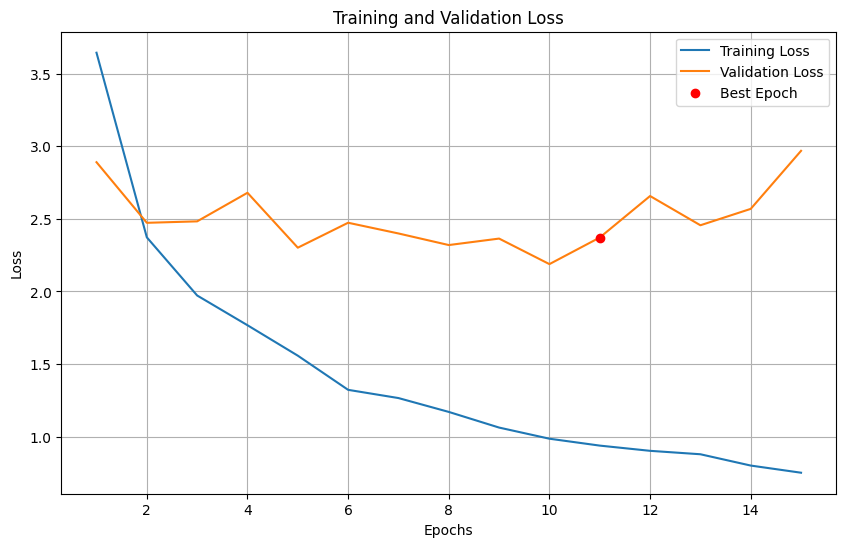

In [18]:
optimizer = torch.optim.AdamW(first_model.parameters(), lr=learning_rate)
best_val_acc, best_params, best_epoch, train_losses, val_losses = train_pipeline(
    first_model,
    train_loader,
    num_epochs,
    validation_loader,
    verbose,
    optimizer,
    patience=patience,
    min_delta=min_delta
)

plot_losses(train_losses, val_losses, best_epoch)

Observations:
* Despite the simplicity of the model, a validation accuracy of around 22% is obtained.
* The model overfits after the first 3 to 4 epochs, despite using dropout layers.

# Second network

In the second model, we introduce **Global Average Pooling (GAP)** layer.

GAP reduces the spatial dimensions of the feature maps by taking a single value per feature map, that is representative for that feature map(it takes the average). It effectively minimizes the number of parameters and reduces the risk of overfitting.

Additionally, this layer completely get rid off the need to compute the additional parameter last_conv_output_size, used in the last network.



In [19]:
batch_size = 64
num_epochs = 40
learning_rate = 1e-3
hidden_dim = 1024
dropout = 0.5

In [20]:

import torch
import torch.nn as nn

class GAPNetwork(nn.Module):
    def __init__(self, hidden_dim, n_classes, conv_layers=None, dropout =0.5):
        super().__init__()

        # Initialize convolutional layers if provided
        self.conv_layers = nn.ModuleList(conv_layers) if conv_layers else nn.ModuleList()

        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))

        last_conv_output_channels = 32  # Adjust based on your last convolutional layer's output

        self.first = nn.Linear(last_conv_output_channels, hidden_dim)
        self.last = nn.Linear(hidden_dim, n_classes)

        self.drop = nn.Dropout(dropout)
        self.relu = nn.ReLU()

    def forward(self, x):
        for layer in self.conv_layers:
            x = layer(x)

        x = self.global_avg_pool(x)
        x = torch.flatten(x, 1)

        x = self.drop(self.relu(self.first(x)))
        x = self.last(x)
        return x

# Define the convolutional layers
conv_layers = [
    nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
]


# Instantiate model
second_model = GAPNetwork(
    hidden_dim,
    n_classes,
    conv_layers=conv_layers,
    dropout = dropout
)

print(second_model)


GAPNetwork(
  (conv_layers): ModuleList(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (global_avg_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (first): Linear(in_features=32, out_features=1024, bias=True)
  (last): Linear(in_features=1024, out_features=43, bias=True)
  (drop): Dropout(p=0.5, inplace=False)
  (relu): ReLU()
)


In [ ]:
optimizer = torch.optim.AdamW(second_model.parameters(), lr=learning_rate)
best_val_acc, best_params, best_epoch, train_losses, val_losses, = train_pipeline(second_model,
                                                       train_loader,
                                                       num_epochs,
                                                       validation_loader,
                                                       verbose,
                                                       optimizer,
                                                       patience=patience,
                                                       min_delta=min_delta)

plot_losses(train_losses, val_losses, best_epoch)

  0%|          | 0/40 [00:00<?, ?it/s]

Our experimental data(progression of training and validation) shows that introducing the GAP layer indeed reduces overfiting.

In the next network, we do not introduce any new types layers, but rather increase the capacity of the network. This choice is inspired by the fact that the previous network barely reaches around 37-40% accuracy, while the target is much higher(around 60%).

It is to mention that we tried parameter fine tuning, but as the improvements in results did not lead to the desired accuracy, we decided to stick with the same hyperparameters from the first model, to have a better comparison between the first two networks, and instead scale up the network in our next model.

## Third model


As mentioned above, we will not add new types of layers, but instead scale up the capacity of the network.

This is done by doubling the number of layers in the convolutional part of the network.
The main structure of the convolutional Layer is the same, consisting of 3 main layers that are repeated and chained:
* Convolution
* ReLU
* MaxPooling
We can consider this 3 layers as an unit block of the convolutional part of our network.

With this notion, we can see that the previous network had 2 such blocks, in which the number of channels was increased(in the Conv2D layers), and the image was downsized(during the MaxPooling layers). In our current network, we add two more such blocks, in which we will keep the trend we described earlier.

In the end, we will have the following network, broken down in 2 parts:
* A convolitional part, in which we have the 4 blocks described before, reaching a number of 128 channels(or feature maps) at the end of this part
* The second part of the network, the output of the convolutional layer is passed through the GAP layer, then through the dense part of the network (Dense layer of size hidden_dim, activation function, and a dropout layer). In the end, the network has a final layer with a number of neurons equal to the number of prediction classes, each neuron coresponding to one class.

In [ ]:
batch_size = 64
num_epochs = 40
learning_rate = 1e-3
hidden_dim = 1024
verbose=True
dropout = 0.5

In [ ]:

import torch
import torch.nn as nn

class LargeGAPNet(nn.Module):
    def __init__(self, hidden_dim, n_classes, conv_layers=None, dropout =0.5):
        super().__init__()

        self.conv_layers = nn.ModuleList(conv_layers) if conv_layers else nn.ModuleList()

        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))

        last_conv_output_channels = 128

        self.first = nn.Linear(last_conv_output_channels, hidden_dim)
        self.last = nn.Linear(hidden_dim, n_classes)

        self.drop = nn.Dropout(dropout)
        self.relu = nn.ReLU()

    def forward(self, x):
        # Pass input through the convolutional layers
        for layer in self.conv_layers:
            x = layer(x)

        # Apply global average pooling
        x = self.global_avg_pool(x)
        x = torch.flatten(x, 1)

        x = self.drop(self.relu(self.first(x)))
        x = self.last(x)
        return x

# Define the convolutional layers
conv_layers = [
    nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
]


# Instantiate model
third_model = LargeGAPNet(
    hidden_dim,
    n_classes,
    conv_layers=conv_layers,
    dropout = dropout
)

print(third_model)

In [ ]:
optimizer = torch.optim.AdamW(third_model.parameters(), lr=learning_rate)
best_val_acc, best_params, best_epoch, train_losses, val_losses = train_pipeline(third_model,
                                                       train_loader,
                                                       num_epochs,
                                                       validation_loader,
                                                       verbose,
                                                       optimizer,
                                                       patience=patience,
                                                       min_delta=min_delta)

plot_losses(train_losses, val_losses, best_epoch)

We can observe that once we significantly increased the capacity of our network, the network tends to overfit faster, and the network does not present an increase in accuracy. To combat this effect, in our next network, we will draw inspiration from already known arhitectures.

## Fourth network



The architecture we draw inspiration is the ResNet architecture.

ResNet introduces skip connections that allow the network to skip certain part of the networks. This network allows the network to choose what parts of the network are best to use in order to achieve the best performance. This structure helps prevent vanishing gradients, enabling the training of very deep networks. (Source: https://arxiv.org/abs/1512.03385)

Stem Layer acts as the initial part of a network, usually consisting of a few convolutional layers with larger filters. It processes the raw input data, reducing its size, and thus the computational cost. Furthermore, it increases the receptive field of the network. (Source: course material)

Batch Normalization is applied after each convolutional layer to normalize the inputs of each layer. This stabilizes and accelerates training by maintaining the mean and variance of the inputs, which improves overall performance and allows for higher learning rates. (Source: https://machinelearningmastery.com/batch-normalization-for-training-of-deep-neural-networks/)

The fourth and last network went though a series of iterations until it reached the form available now.
* In the beginning, the residual connections were added and was observed that the overfitting of the network was reduced.
* A progression of parameter fine tunning and network capacity increase followed.

In the end, the network has:
* One Stem Layer that downsizes the input data, helping decrease the computational cost and the memory required by the network
* 3 ResNet blocks that allow the network to skip certain layers of the network if this would yield a better result.
* Global Average Pool Layer that was introduced and explained previously
* A short succession of Dense Layers(with the afferent Activation and Dropout layers) that allow the network to better learn how to classify the data.


Notable mentions:
* It was decided to remove the early stopping criterion, as the physical limits of our setup were reached. The network achieves consistently around 60 percent when the ending is nearing, thus the patience was set to be equal to the number of epochs.
*  One of the most notable differences in network training and performance was achieved by the decrease of the learning rate from 1e-3 to 1e-4. In our case, this greatly increased the stability during training.
* We considered that in order to have a have a fair comparison between the models, some of the hyperparameters will remain the same, as they yeilded good enough results to show the thought process behind the 4 CNN iterations provided. In the case of the last network, through experiments, we arrived at final set of hyperparameters.(Some of the hyperparameters were tuned for the final model(i.e the batch size or the number of epochs), and used for the previous models. The results of the three previous networks did not significantly modify when this change in hyperparameters were made)

The final set of the main hyperparameters of the network are defined below.

In [ ]:
batch_size = 64
num_epochs = 40
learning_rate = 1e-4
verbose=True
hidden_dim = 1024
dropout = 0.5
patience = 40
min_delta = 0

In [ ]:
# the ResBlock was inspired from the course material
import torch
import torch.nn as nn
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):

        super(ResBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        #skip connection with 1x1 convolution to match the relevant output dimensions of the other branch of the module
        self.skip_conn = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
            nn.BatchNorm2d(out_channels)
        )

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        identity = self.skip_conn(x)

        out += identity
        out = self.relu(out)

        return out


In [ ]:
class StemLayer(nn.Module):
    def __init__(self):
        super(StemLayer, self).__init__()

        # 5x5 kernel and stride of 2
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=7, stride=2, padding=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=1, padding=1)

        # 3x3 kernel and stride of 2
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=1, padding=1)


    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.maxpool1(x)


        x = self.conv2(x)
        x = self.bn2(x)
        x = self.maxpool2(x)


        return x


In [ ]:
import torch
import torch.nn as nn

class ResidualNetwork(nn.Module):
    def __init__(self, hidden_dim, n_classes, dropout):

        super(ResidualNetwork, self).__init__()

        # stem layer
        self.stem_layer = StemLayer()

        self.res1 = ResBlock(32, 64, stride=1)

        self.res2 = ResBlock(64, 128, stride=1)

        self.res3 = ResBlock(128, 256, stride=1)

        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)


        # Initialize the fully connected layers
        self.first = nn.Linear(256, hidden_dim)
        self.hidden = nn.Linear(hidden_dim, hidden_dim//2)
        self.last = nn.Linear(hidden_dim//2, n_classes)

        self.drop = nn.Dropout(dropout)
        self.relu = nn.ReLU()


    def forward(self, x):
        x = self.stem_layer(x)

        x = self.res1(x)

        x = self.res2(x)

        x = self.res3(x)

        x = self.global_avg_pool(x)
        x = torch.flatten(x, 1)

        x = self.drop(self.relu(self.first(x)))
        x = self.drop(self.relu(self.hidden(x)))

        x = self.last(x)

        return x



# Instantiate model
fourth_model = ResidualNetwork(
    hidden_dim = hidden_dim,
    n_classes = n_classes,
    dropout = dropout)

print(fourth_model)

ResidualNetwork(
  (stem_layer): StemLayer(
    (conv1): Conv2d(3, 16, kernel_size=(7, 7), stride=(2, 2), padding=(2, 2))
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU()
    (maxpool1): MaxPool2d(kernel_size=2, stride=1, padding=1, dilation=1, ceil_mode=False)
    (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU()
    (maxpool2): MaxPool2d(kernel_size=2, stride=1, padding=1, dilation=1, ceil_mode=False)
  )
  (res1): ResBlock(
    (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_

  0%|          | 0/40 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch 0: train loss 3.415 - train acc 0.158 - valid loss 3.225 - valid acc 0.233
Epoch 0: best acc 0.233
Epoch 3: train loss 2.197 - train acc 0.378 - valid loss 2.370 - valid acc 0.321
Epoch 3: best acc 0.321
Epoch 6: train loss 1.705 - train acc 0.481 - valid loss 1.970 - valid acc 0.432
Epoch 6: best acc 0.432
Epoch 9: train loss 1.397 - train acc 0.555 - valid loss 1.823 - valid acc 0.429
Epoch 9: best acc 0.443
Epoch 12: train loss 1.214 - train acc 0.596 - valid loss 1.748 - valid acc 0.459
Epoch 12: best acc 0.500
Epoch 15: train loss 1.069 - train acc 0.647 - valid loss 1.723 - valid acc 0.476
Epoch 15: best acc 0.500
Epoch 18: train loss 0.877 - train acc 0.710 - valid loss 1.785 - valid acc 0.443
Epoch 18: best acc 0.500
Epoch 21: train loss 0.787 - train acc 0.738 - valid loss 1.864 - valid acc 0.486
Epoch 21: best acc 0.581
Epoch 24: train loss 0.716 - train acc 0.767 - valid loss 1.785 - valid acc 0.463
Epoch 24: best acc 0.581
Epoch 27: train loss 0.604 - train acc 0.800 

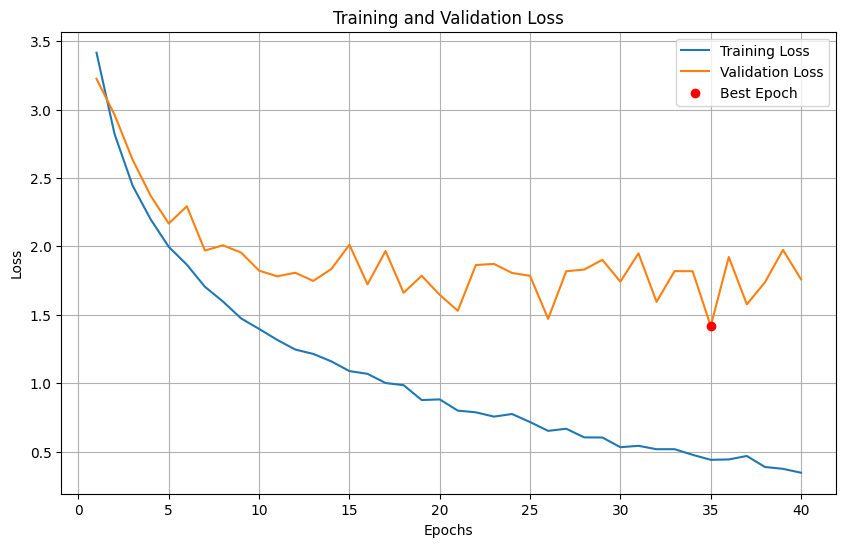

In [ ]:
optimizer = torch.optim.AdamW(fourth_model.parameters(), lr=learning_rate)
best_val_acc, best_params, best_epoch, train_losses, val_losses = train_pipeline(fourth_model,
                                                       train_loader,
                                                       num_epochs,
                                                       validation_loader,
                                                       verbose,
                                                       optimizer,
                                                       patience=patience,
                                                       min_delta=min_delta)

plot_losses(train_losses, val_losses, best_epoch)

We can see that the network val loss bottlenecks from the halfway onwards during training. We suspect this is either because of overfitting, or because we would need a bigger model in order to get better nuances of the data.

## Part 2: fine-tune an existing network

Your goal is to fine-tune a pretrained **ResNet-18** model on `GroceryStoreDataset`. Use the implementation provided by PyTorch, do not implement it yourselves! (i.e. exactly what you **could not** do in the first part of the assignment). Specifically, you must use the PyTorch ResNet-18 model pretrained on ImageNet-1K (V1). Divide your fine-tuning into two parts:

1. First, fine-tune the Resnet-18 with the same training hyperparameters you used for your best model in the first part of the assignment.
1. Then, tweak the training hyperparameters in order to increase the accuracy on the validation split of `GroceryStoreDataset`. Justify your choices by analyzing the training plots and/or citing sources that guided you in your decisions (papers, blog posts, YouTube videos, or whatever else you find enlightening). You should consider yourselves satisfied once you obtain a classification accuracy on the **validation** split **between 80 and 90%**.

### BASE RESNET MODEL

We'll start by importing the Resnet18 model from torchvision.models.
Specifically, we'll use the pretrained version of the model, which has been trained on the ImageNet dataset.

In [ ]:
#import resnet18 and use it as a pretrained model
from torchvision import models

resnet18 = models.resnet18(weights='IMAGENET1K_V1')
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### HYPERPARAMETERS

These are the hyperparameters that we used to train the previous model, we will use them to train the resnet18 model

In [ ]:
batch_size = 64
num_epochs = 45
learning_rate = 1e-4
verbose=True
hidden_dim = 768
dropout = 0.6

### BASE RESNET TRAINING

In [ ]:
optimizer = torch.optim.AdamW(resnet18.parameters(), lr=learning_rate)
best_val_acc, best_params, best_epoch = train_pipeline(resnet18,
                                                       train_loader,
                                                       num_epochs,
                                                       validation_loader,
                                                       verbose,
                                                       optimizer)


  0%|          | 0/45 [00:00<?, ?it/s]

c:\Users\BandoleroNext\anaconda3\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch 0: train loss 2.638 - train acc 0.586 - valid loss 1.341 - valid acc 0.672
Epoch 0: best acc 0.672
Epoch 3: train loss 0.022 - train acc 1.000 - valid loss 0.823 - valid acc 0.770
Epoch 3: best acc 0.770
Epoch 6: train loss 0.006 - train acc 1.000 - valid loss 0.769 - valid acc 0.780
Epoch 6: best acc 0.780
Epoch 9: train loss 0.003 - train acc 1.000 - valid loss 0.772 - valid acc 0.770
Epoch 9: best acc 0.780
Epoch 12: train loss 0.002 - train acc 1.000 - valid loss 0.742 - valid acc 0.791
Epoch 12: best acc 0.791
Epoch 15: train loss 0.002 - train acc 1.000 - valid loss 0.763 - valid acc 0.787
Epoch 15: best acc 0.801
Epoch 18: train loss 0.001 - train acc 1.000 - valid loss 0.749 - valid acc 0.797
Epoch 18: best acc 0.801
Epoch 21: train loss 0.009 - train acc 0.998 - valid loss 0.926 - valid acc 0.774
Epoch 21: best acc 0.801
Epoch 24: train loss 0.004 - train acc 0.999 - valid loss 0.724 - valid acc 0.804
Epoch 24: best acc 0.804
Epoch 27: train loss 0.016 - train acc 0.997 

### RESULTS

The ResNet model trained in the previous cell achieved an accuracy of 83% on the validation split of the GroceryStoreDataset.

This is a significant improvement compared to the initial accuracy of around 63% achieved by the custom SimpleClassifier model.

Fine-tuning the pretrained ResNet-18 model on the GroceryStoreDataset allowed us to leverage the prelearned features from the ImageNet dataset,
resulting in better performance on our specific classification task.

Futhermore, the initial guesses for the hyperparameters were good enough to achieve a good accuracy.

Further improvements could be made by adjusting the training hyperparameters and exploring different optimization techniques.

### TESTING

One thing worth mentioning was the total running for the Resnet training: 1 hour and 30 minutes.

Judging by the epoch timeline, it seems that the first few epochs are the most important, the model converges quickly and it spends a lot of time updating the weights to get the same results.

Different tries have been made by changing the hyperparameters, but most of them were downgrading the results.
Promising results were shown by implementing transfer learning techniques


### TRANSFER LEARNING

As explained in this [paper](https://paperswithcode.com/paper/bag-of-tricks-for-image-classification-with) and an [implementation](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/06_pytorch_transfer_learning.ipynb) of the aforementioned paper: <br />"Transfer learning is an approach to machine learning where a model trained on one task is used as the starting point for a model on a new task. This is done by transferring the knowledge that the first model has learned about the features of the data to the second model"


The process of transfer learning usually goes: freeze some base layers of a pretrained model (typically the features section) and then adjust the output layers (also called head/classifier layers) to suit our needs.

To freeze layers means to keep them how they are during training.
In essence, we'd like to keep the pretrained weights/patterns our model has learned from ImageNet as a backbone and then only change the output layers.



Transfer learning significantly enhances the performance of machine learning models by leveraging pre-trained models on large datasets. The key improvements are:

1. **Reduced Training Time**: Transfer learning allows us to use pre-trained models, which significantly reduces the time required for training compared to training a model from scratch.

2. **Improved Accuracy**: Pre-trained models have already learned useful features from large datasets, which can be fine-tuned for specific tasks, leading to higher accuracy and better performance.

3. **Less Data Requirement**: Transfer learning models can achieve good performance even with smaller datasets, as they benefit from the knowledge gained from the large datasets used to pre-train the models.

4. **Better Generalization**: By using pre-trained models, transfer learning helps in better generalization on new tasks, as the models have already learned a wide variety of features.

### TRANSFER LEARNING MODEL

We'll start by instantiating the base resnet model again

In [ ]:
#Instantiate the model
resnet18 = models.resnet18(weights='IMAGENET1K_V1')
print(resnet18)

We then decide to freeze the entire resnet given his weights form Imagenet, and then implement a new classifier layer at the end of the Resnet

In [ ]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in resnet18.parameters():
    param.requires_grad = False


In [ ]:

# Define the new classifier to be attached to the resnet18 model

class Resnet18Classifier(nn.Module):
    def __init__(self, hidden_dim, n_classes, dropout):
        super(Resnet18Classifier, self).__init__()
        self.resnet18 = resnet18
        in_features = resnet18.fc.in_features
        self.resnet18.fc = nn.Identity()
        self.fc = nn.Sequential(
            nn.Linear(in_features, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, n_classes)
        )

    def forward(self, x):
        x = self.resnet18(x)
        x = self.fc(x)

        return x



We instantiate the model with the same parameters

In [ ]:
# Instantiate the new model

resnet18_classifier = Resnet18Classifier(
    hidden_dim = hidden_dim,
    n_classes = n_classes,
    dropout = dropout
)

print(resnet18_classifier)

### TRANSFER LEARNING MODEL TRAINING

In [ ]:
# Instantiate an AdamW optimizer for the model
optimizer = torch.optim.AdamW(resnet18_classifier.parameters(), lr=learning_rate)

# Train the model
best_val_acc, best_params, best_epoch = train_pipeline(resnet18_classifier,
                                                       train_loader,
                                                       num_epochs,
                                                       validation_loader,
                                                       verbose,
                                                       optimizer)

  0%|          | 0/45 [00:00<?, ?it/s]

c:\Users\BandoleroNext\anaconda3\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch 0: train loss 0.013 - train acc 0.998 - valid loss 0.690 - valid acc 0.811
Epoch 0: best acc 0.811
Epoch 3: train loss 0.001 - train acc 1.000 - valid loss 0.509 - valid acc 0.838
Epoch 3: best acc 0.848
Epoch 6: train loss 0.002 - train acc 0.999 - valid loss 0.684 - valid acc 0.814
Epoch 6: best acc 0.851
Epoch 9: train loss 0.030 - train acc 0.992 - valid loss 0.582 - valid acc 0.811
Epoch 9: best acc 0.851
Epoch 12: train loss 0.027 - train acc 0.994 - valid loss 0.782 - valid acc 0.818
Epoch 12: best acc 0.851
Epoch 15: train loss 0.002 - train acc 1.000 - valid loss 0.689 - valid acc 0.801
Epoch 15: best acc 0.851
Epoch 18: train loss 0.001 - train acc 1.000 - valid loss 0.627 - valid acc 0.814
Epoch 18: best acc 0.851
Epoch 21: train loss 0.000 - train acc 1.000 - valid loss 0.571 - valid acc 0.834
Epoch 21: best acc 0.851
Epoch 24: train loss 0.001 - train acc 1.000 - valid loss 0.548 - valid acc 0.831
Epoch 24: best acc 0.851
Epoch 27: train loss 0.001 - train acc 1.000 

### RESULTS

The transfer learning model, where we froze the base layers of the ResNet-18 model and added a new classifier layer, achieved an accuracy of 87% on the validation split of the GroceryStoreDataset.

This is a significant improvement compared to the initial accuracy of around 83% achieved by fine-tuning the entire ResNet-18 model.

By freezing the base layers, we were able to leverage the pre-trained features from the ImageNet dataset and focus on training the new classifier layer specifically for our classification task.

The improved accuracy demonstrates the effectiveness of transfer learning in improving model performance and reducing training time.

Further improvements could be made by adjusting the training hyperparameters, exploring different optimization techniques, or fine-tuning additional layers of the ResNet-18 model.